In [1]:
%matplotlib inline
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
import tensorflow as tf

import model
import apascal_input as data_input

[aPascal Dataset Configuration]
	Dataset root: /home/dalgu/dataset/apascal/dataset_crop_total/
	Number of attributes: 25
[Network Configuration]
	Batch size: 32
	L2 loss weight: 0.000100
	L1 loss weight: 0.001000
	Basenet Training: True
	Basenet lr ratio: 0.100000
	Moving average decay: 0.990000
	Number of epochs per decay: 50.000000
	Learning rate decay factor: 0.100000
	Initial learning rate 0.100000
	Max gradient norm 1.000000


In [2]:
def normalized_norm_plot(ckpt_path, weight_out_path):    
    # Load attribute names / layer names
    attr_names_path = '/home/dalgu/dataset/apascal/attribute_names_apy25.txt'
    # attr_names_path = '/data/common_datasets/apascal/attribute_names_apy25.txt'
    
    with open(attr_names_path, 'r') as fd:
        attr_names = [temp.strip() for temp in fd.readlines()]
        
    layer_names = ['conv1', 'res2a', 'res2b', 'res2c', 'res3a', 'res3b', 'res3c', 'res3d', 'res4a', 'res4b',
                   'res4c', 'res4d', 'res4e', 'res4f', 'res5a', 'res5b', 'res5c', 'pool', 'prob']
    num_layer = len(layer_names)
        
    # Build caffenet model & Restore from the checkpoint file
    print "Checkpoint file: " + ckpt_path    
    print "Output file: " + weight_out_path
    tf.reset_default_graph() # Free all the tensors

    test_images, test_labels = model.inputs(True) # False OK
    test_probs = model.inference(test_images)

    init = tf.initialize_all_variables()
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.45)))
    sess.run(init)

    saver = tf.train.Saver(tf.all_variables())
    saver.restore(sess, ckpt_path)
    
    # Load all weights/biases
    weights_list, biases_list = ([], [])

    var_list = tf.all_variables()

    # In the last of list var_list, tensors are stored as
    # [..., "prob/weights1:0", "prob/biases1:0", ..., "prob/weights25:0", "prob/biases25:0"]
    num_attr = len(attr_names)
    for i in range(num_attr):
        w_t = var_list[-(2*(num_attr-i))]
        b_t = var_list[-(2*(num_attr-i))+1]
        w_val, b_val = sess.run([w_t, b_t])
        weights_list.append(w_val.ravel().tolist())
        biases_list.append(b_val[0])
    
    # Print weight statistics    
    format_str = '%-12s - %.5e\t ~ %.5e\t, (%.5e, %.5e)'
    print " ===================="
    print 'name         -  min      \t~ max      \t, (average\t, std)'
    for weight, name in zip(weights_list, attr_names):
        print format_str % (name, np.min(weight), np.max(weight), np.average(weight), np.std(weight))
        
    print " ===================="
    weights_list_np = np.array(weights_list)
    biases_list_np = np.array(biases_list)
    print "Number of zero weights: %d" % np.sum(np.abs(weights_list_np) == 0)
    print "Number of weights under 10^-9: %d" % np.sum(np.abs(weights_list_np) < 10**-9)
    print "Number of weights under 10^-7: %d" % np.sum(np.abs(weights_list_np) < 10**-7)
    print "Number of weights under 10^-5: %d" % np.sum(np.abs(weights_list_np) < 10**-5)
    print "Number of weights under 10^-3: %d" % np.sum(np.abs(weights_list_np) < 10**-3)
        
    # (Take absolute and) Normalize weights
    weights_list_norm = np.zeros([num_attr, num_layer], dtype=np.float32)
    for i in range(num_attr):
        temp = np.abs(weights_list[i])
        weights_list_norm[i, :] = temp / sum(temp)

    # Visualize the normalized weights
    attr_per_col = 25
    plt_scale = 0.5
    ncols = int(np.ceil(float(num_attr)/float(attr_per_col)))

    plt.figure(figsize=(((num_layer+4.0)*ncols+1.0)*plt_scale, attr_per_col*plt_scale))

    for i in range(ncols):
        fig = plt.subplot(1, ncols, i+1)

        temp_weights_list = weights_list_norm[i*attr_per_col:(i+1)*attr_per_col,:]
        temp_attr_names = attr_names[i*attr_per_col:(i+1)*attr_per_col]
        temp_row_cnt = len(temp_attr_names)

        plt.imshow(temp_weights_list, interpolation='nearest', vmin=0.0, vmax=1.0)

        plt.xticks(range(num_layer), layer_names, rotation=90)
        fig.xaxis.set_ticks_position('top')
        plt.yticks(range(temp_row_cnt), temp_attr_names)

    plt.colorbar(aspect=30)

    # format_str = '%-15s %f %f %f %f %f %f %f %f'
    format_str = '%-13s' + ' %.2f' * num_layer
    print " ===================="
    for i in range(num_attr):
        arg_list = tuple([attr_names[i].replace(' ', '-')] + weights_list_norm[i].tolist())
        print(format_str % arg_list)
    
    with open(weight_out_path, 'wb') as fd:
        pickle.dump({attr:(weight, bias) for attr, weight, bias in zip(attr_names, weights_list, biases_list)}, fd)
    
    return weights_list_np, biases_list_np

Checkpoint file: train_loss_weight2/model.ckpt-3500
Output file: train_loss_weight2/l1_weight.pkl
	Load file list from /home/dalgu/dataset/apascal/dataset_crop_total/test_apy25.txt
	Total 7668 files


/home/dalgu/.virtualenvs/venv_tf/local/lib/python2.7/site-packages/tensorflow/python/ops/image_ops.py:635: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if width == new_width_const and height == new_height_const:


	Total 19 bypass layers
name         -  min      	~ max      	, (average	, std)
2D Boxy      - -6.94089e-01	 ~ 1.40661e-01	, (-5.08825e-02, 1.88117e-01)
3D Boxy      - -8.17971e-01	 ~ 2.64673e-01	, (-2.52285e-02, 1.97003e-01)
Round        - -7.55735e-01	 ~ 2.12963e-02	, (-7.09139e-02, 1.87358e-01)
Vert Cyl     - -8.37632e-01	 ~ 3.29525e-01	, (-4.13524e-02, 2.13255e-01)
Horiz Cyl    - -7.48066e-01	 ~ 2.97571e-01	, (-6.70559e-02, 2.07343e-01)
Ear          - -6.62862e-01	 ~ 5.72303e-01	, (-3.87790e-03, 2.06160e-01)
Snout        - -6.42398e-01	 ~ 3.84792e-01	, (-6.34305e-02, 2.14736e-01)
Nose         - -7.53239e-01	 ~ 4.21883e-01	, (-1.77386e-02, 1.98016e-01)
Mouth        - -6.69342e-01	 ~ 2.95808e-01	, (-3.65413e-02, 2.13600e-01)
Hair         - -6.40491e-01	 ~ 3.91257e-01	, (-3.78467e-02, 1.86069e-01)
Face         - -6.45915e-01	 ~ 3.58837e-01	, (-4.00880e-02, 1.96860e-01)
Eye          - -6.87204e-01	 ~ 2.86168e-01	, (-3.50403e-02, 2.01858e-01)
Skin         - -6.35597e-01	 ~ 4.53040e-01	,

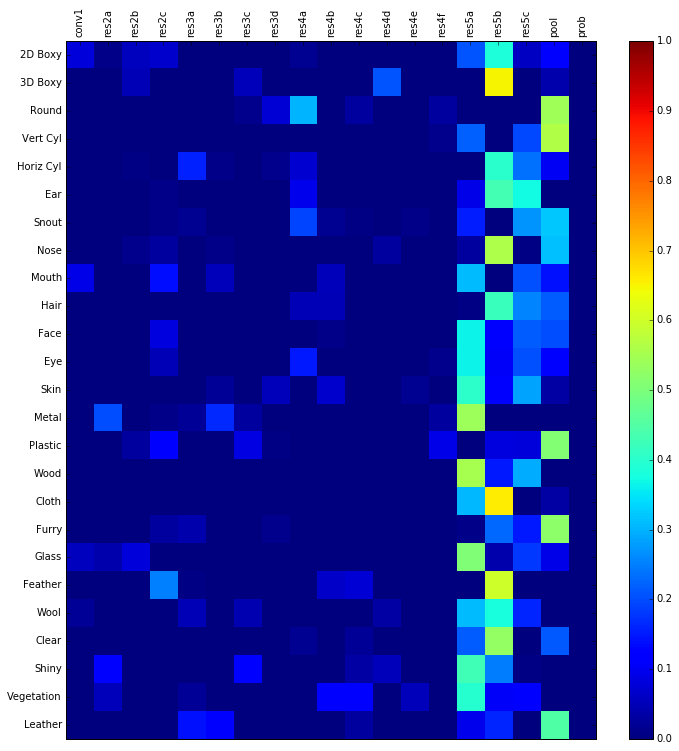

In [3]:
weights_list, biases_list = normalized_norm_plot('train_loss_weight2/model.ckpt-3500',
                                                 'train_loss_weight2/l1_weight.pkl')